# Regularization

This dataset contains various statistics from IMBD for over 5000 movies. For our purposes we will only be interested in the IMDb rating and gross sales revenue. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the IMDb data
movie_data = pd.read_csv('movie_metadata.csv')
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## Data cleaning and summary stats

We will keep the following
- only US movies 
- imdb score
- gross revenue

We will also convert the movie gross sales revenue in terms of 2017 dollar by assuming a 2.5% yearly inflation rate. Also since we are dealing with real data, we need to take missing values into consideration. Finally, for the purposes of illustrating overfitting on a scatter plot, we will be randomly dropping 90% of the data.

In [3]:
# Drop rows with missing gross revenue data (standard practice in regression analysis)
movie_data = movie_data.dropna(subset = ['gross'])

# Only keep data on movies from the US
movie_data = movie_data[movie_data['country'] == "USA"]

# Assuming a average US inflation rate of 2.5%, we convert gross revenue in terms of 2017 dollars
movie_data[['gross']] = (1.025**(2017-movie_data['title_year']))*movie_data['gross']

# Only keep the variables of interest, 'imdb_score' and 'gross'
movie_data = movie_data[['gross','imdb_score']]

# Let's scale the gross revenue to be in millions of dollars so its easier to read
movie_data[['gross']] = movie_data[['gross']]/1000000

# Randomly drop 90% of the data so overfitting from high degree polynomial can be seen on scatter plot

# Set seed so we get same random allocation on each run of code
np.random.seed(2017)

# Add column vector with observations generated randomly from U[0,1] distribution
movie_data["uniform"] = list(np.random.uniform(0,1, len(movie_data.index)))

# Only keep observations if uniform < 0.1 (this is randomly dropping 90% of data)
movie_data = movie_data[movie_data["uniform"] < 0.1]

# Drop uniform column, we just added it in to randomly drop 90% of observations
movie_data = movie_data[['gross','imdb_score']]
 
# Summary statistics (mean, stdev, min, max)
movie_data.describe()

,gross,imdb_score
count,303.000000,303.000000
mean,73.772574,6.371947
std,122.921231,1.050058
min,0.014931,2.100000
25%,9.921675,5.800000
50%,35.337785,6.500000
75%,82.631405,7.100000
max,1079.311263,9.300000


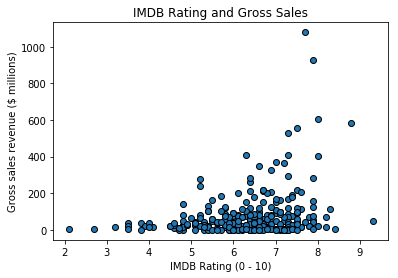

In [4]:
# Visualize data
plt.scatter(movie_data['imdb_score'], movie_data['gross'], edgecolor='black')
plt.title('IMDB Rating and Gross Sales')
plt.ylabel('Gross sales revenue ($ millions)')
plt.xlabel('IMDB Rating (0 - 10)');

## Estimating linear model parameters

We will use well known closed form solutions to implement standard linear regression and $L2$ regularization. Using matrices, we can re-write the assumed true linear relationship between $y_{i}$ and $x_{i}$ as

$$\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{n}
\end{bmatrix} 
=
\begin{bmatrix}
    1 & x_{11} & \ldots & x_{k1}\\
    \vdots & \vdots & \ldots & \vdots \\
    1 & x_{12} & \ldots & x_{k2}\\
    1 & x_{1n} & \ldots & x_{kn}
\end{bmatrix} 
\begin{bmatrix}
    \beta_{0} \\
    \beta_{1} \\
    \vdots \\
    \beta_{k}
\end{bmatrix} 
+
\begin{bmatrix}
    \epsilon_{1} \\
    \epsilon_{2} \\
    \vdots \\
    \epsilon_{n}
\end{bmatrix}.
$$
Using outcome vector $y$, coeffecient vector $\beta$, error vector $\epsilon$, and covariate matrix $X$ (also known as design matrix), we can re-write the above equation as $y = X\beta + \epsilon.$ For the standard square loss function, the closed form solution for the parameters is $\hat{\beta} = (X'X)^{-1}X'y,$ and for the $L2$ regularized loss function the closed form solution is $\hat{\beta} = (X'X + \lambda I)^{-1}X'y,$ where I = 
$
\begin{bmatrix}
    0 & 0 & \ldots & 0\\
    0 & 1 & \ldots & 0\\
    0 & 0 & 1 & 0 \\
    \vdots & \vdots & \ldots & \vdots \\
    0 & 0 & \ldots & 1
\end{bmatrix}. 
$
Note that the $L1$ regularized loss function doesn't have a closed form solution for the parameters so we have to use numerical methods to implement it. We will not be implementing the $L1$ regularized method here since the result will likely be similar to $L2$ for our small data set. We will pick $\lambda = 5,$ and discuss a more formal method of choosing this tuning parameter in a future notebook.


## Deriving the closed form solutions
It's actually intuitive to formulate the closed form solutions showed for the standard linear and ridge regression. For ridge regression, the matrix representation of the $L2$ loss function is $$Error_{L2}(\beta) = \frac{1}{2}(f(x;\beta) - y)'(f(x;\beta) - y)+\frac{\lambda}{2}\beta'\beta,$$ where $y$ is outcome vector, $f(x,\beta) = X\beta$ is vector of linear model predictions, and $\beta$ is parameter vector. To estimate $\beta$, we minimize $Error_{L2}(\beta)$ and hence compute $\frac{d Error_{L2}(\beta)}{d\beta} = 0.$ After differentiation $Error_{L2}(\beta)$ with respect to $\beta$ we can obtain $$X'X\beta-X'y+\lambda I\beta = 0,$$ and rearranging the above equation results in $\hat{\beta} = (X'X + \lambda I)^{-1}X'y$, the closed form solution for ridge regression. The closed form solution for the standard linear regression with square loss can be derived in a similar manner. 

In [5]:
# Implement closed form solutions for linear and L2 norm regression
def estimate_model(y,X,Lambda):
    
    # X transpose
    Xtranspose = np.matrix.transpose(X)
    
    # Identity matrix (number of parameters is the dimension)
    Identity = np.identity(len(X[1,:]))
    
    # We don't add penalty to intercept
    Identity[0,0] = 0
    
    # Closed form solution is BetaHat = inv(X'X + Lambda*I)*X'y
    # Estimate model parameters (if Lambda = 0, we get standard square loss function result)
    BetaHat = np.dot(np.linalg.inv(np.add(np.dot(Xtranspose,X),Lambda*Identity)),np.dot(Xtranspose,y))
    
    return BetaHat

In [6]:
# Estimate a one degree linear regression model (using standard square loss function)
# Simple linear regression is y = B0 + B1*x

# Define outcome vector (gross movie sales revenue)
outcome = np.array(movie_data['gross'])

# Define covariate (IMDB movie rating)
imdb_score = np.array(movie_data['imdb_score'])

# Vector of ones (for B0)
ones = np.ones(len(imdb_score))

# Define design matrix
design_simple = np.column_stack((ones,imdb_score))

# Estimate (Beta0, Beta1) for simple linear regression model
betahat_simple = estimate_model(outcome,design_simple,0)
print(betahat_simple)

[-121.62584521   30.66541721]


In [7]:
# Estimate a five degree linear regression model (using standard square loss function)
# Mutiple linear regression is y = B0 + B1*x + B2*x^2 + ... + B5*x^5

# Define higher order covariates 
imdb_score2 = np.power(imdb_score,2)
imdb_score3 = np.power(imdb_score,3)
imdb_score4 = np.power(imdb_score,4)
imdb_score5 = np.power(imdb_score,5)

# Define design matrix
design_multiple = np.column_stack((ones,imdb_score, imdb_score2, imdb_score3, imdb_score4, imdb_score5))

# Estimate (Beta0, Beta1, Beta2, Beta3, Beta4, and Beta5) for multiple linear regression model
betahat_multiple = estimate_model(outcome,design_multiple,0)
print(betahat_multiple)

[ 3.04527263e+03 -3.43064828e+03  1.43909987e+03 -2.83201919e+02
  2.64343139e+01 -9.39844505e-01]


In [8]:
# Estimate a L2 regularized loss function regression (also known as ridge regression)
# Multiple linear regression is y = B0 + B1*x + B2*x^2 + ... + B5*x^5

# Estimate (Beta0, Beta1, Beta2, Beta3, Beta4, and Beta5) for ridge regression
# We set Lambda = 5 as the tuning parameters for L2 regularization
betahat_multiple_L2 = estimate_model(outcome,design_multiple,5)
print(betahat_multiple_L2)

[-66.93302342  11.065262    31.65362852 -12.57289485   1.68560811
  -0.07189237]


Notice how the estimated parameters for the ridge regression ($L2$ loss) are closer to $0$ than the estimated parameters from the multiple linear regression (standard square loss) as expected. 

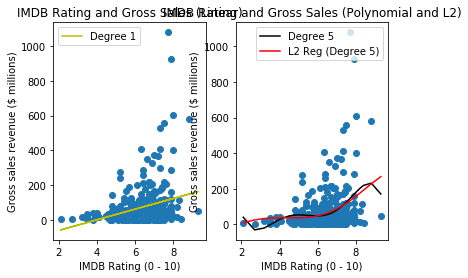

In [9]:
# Visualize simple linear regression (degree 1), figure on the left
plt.subplot(1, 2, 1)
plt.scatter(movie_data['imdb_score'], movie_data['gross'])

# Chart title
plt.title('IMDB Rating and Gross Sales (Linear)')

# y-label
plt.ylabel('Gross sales revenue ($ millions)')

# x-label
plt.xlabel('IMDB Rating (0 - 10)')

# Plot simple linear regression (degree 1)
simple, = plt.plot(imdb_score, betahat_simple[0] + imdb_score*betahat_simple[1], 'y')

# Legend for simple linear regression scatter plot, plot on left
plt.legend([simple], ['Degree 1'])

# Visualize multiple linear regression (degree 5) and L2 loss function (degree 5), figure on the right
plt.subplot(1, 2, 2)
plt.scatter(movie_data['imdb_score'], movie_data['gross'])

# Chart title
plt.title('IMDB Rating and Gross Sales (Polynomial and L2)')

# y-label
plt.ylabel('Gross sales revenue ($ millions)')

# x-label
plt.xlabel('IMDB Rating (0 - 10)')

# Plot multiple linear regression (degree 5)
multiple, = plt.plot(np.sort(imdb_score), betahat_multiple[0] + np.sort(imdb_score)*betahat_multiple[1] 
         + np.sort(imdb_score2)*betahat_multiple[2] + np.sort(imdb_score3)*betahat_multiple[3] 
         + np.sort(imdb_score4)*betahat_multiple[4] + np.sort(imdb_score5)*betahat_multiple[5],'-k')

# Plot ridge regression (L2 loss function with degree 5)
ridge, = plt.plot(np.sort(imdb_score), betahat_multiple_L2[0] + np.sort(imdb_score)*betahat_multiple_L2[1] 
        + np.sort(imdb_score2)*betahat_multiple_L2[2] + np.sort(imdb_score3)*betahat_multiple_L2[3] 
         + np.sort(imdb_score4)*betahat_multiple_L2[4] + np.sort(imdb_score5)*betahat_multiple_L2[5],'r')

# Set legend for plot on the right
plt.legend([multiple, ridge], ['Degree 5','L2 Reg (Degree 5)']);

## Conclusion
The left plot shows a simple degree 1 linear regression model (square loss) fit to the data, and the right figure illustrates a degree 5 linear regression polynomial (square loss) as well as degee 5 ridge regression ($L2$ loss). From the figure on the left, the line (yellow) doesn't seem to fit the data well as it does not capture the non-linearities in gross revenues for higher rated movies, and predicts negative gross revenues for low rated movies. In contrast, although the degree 5 polynomial (black) shown to the right camptures nonlinear patterns in the data, it seems to overfit the data as it predicts decreasing gross sales revenue for the highly rated movies. Finally the ridge regression (degree 5 with $L2$ loss) shown to the right seems to be "just correct" as it captures the non-linear increase in gross sales revenue with increasing movie rating. 